In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import math as math
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']

  del save  # hint to help gc free up memory
    
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)

  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [13]:
'''
Model:

--> NN with 5 hidden layers
    > RELUs
    
--> Overfitting measures
    > L2 Regularization
        -> Learning rate (beta) with exponential decay
    > Dropout
    
--> 10,000 steps or more

'''

batch_size = 128
beta = 0.00001

hidden_nodes_1 = 1024
hidden_nodes_2 = hidden_nodes_1
hidden_nodes_3 = hidden_nodes_1
hidden_nodes_4 = hidden_nodes_1
hidden_nodes_5 = hidden_nodes_1

graph = tf.Graph()
with graph.as_default():

    '''Input Data'''
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_labels = tf.constant(test_labels)
    #Placeholder for dropout probability
    keep_prob = tf.placeholder("float")

    '''Variables'''
    # Hidden RELU layer 1
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_1], stddev=math.sqrt(2.0/(image_size*image_size))))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))

    # Hidden RELU layer 2
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=math.sqrt(2.0/hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    
    # Hidden RELU layer 3
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=math.sqrt(2.0/hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    
    # Hidden RELU layer 4
    weights_4 = tf.Variable(tf.truncated_normal([hidden_nodes_3, hidden_nodes_4], stddev=math.sqrt(2.0/hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([hidden_nodes_4]))
    
    # Hidden RELU layer 5
    weights_5 = tf.Variable(tf.truncated_normal([hidden_nodes_4, hidden_nodes_5], stddev=math.sqrt(2.0/hidden_nodes_4)))
    biases_5 = tf.Variable(tf.zeros([hidden_nodes_5]))
    
    # Output layer
    output_weights = tf.Variable(tf.truncated_normal([hidden_nodes_5, num_labels], stddev=math.sqrt(2.0/hidden_nodes_5)))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    
    
    '''Training computation'''
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    hidden_layer_1_dropout = tf.nn.dropout(hidden_layer_1, keep_prob)
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(hidden_layer_1_dropout, weights_2) + biases_2
    hidden_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_2_dropout = tf.nn.dropout(hidden_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(hidden_layer_2, weights_3) + biases_3
    hidden_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_3_dropout = tf.nn.dropout(hidden_layer_3, keep_prob)
    
    # Hidden RELU layer 4
    logits_4 = tf.matmul(hidden_layer_3, weights_4) + biases_4
    hidden_layer_4 = tf.nn.relu(logits_4)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_4_dropout = tf.nn.dropout(hidden_layer_4, keep_prob)
    
    # Hidden RELU layer 5
    logits_5 = tf.matmul(hidden_layer_4, weights_5) + biases_5
    hidden_layer_5 = tf.nn.relu(logits_5)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_5_dropout = tf.nn.dropout(hidden_layer_5, keep_prob)
    
    # Output layer
    output_logits = tf.matmul(hidden_layer_5, output_weights) + output_biases
    
    
    # Normal loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output_logits, labels = tf_train_labels))
    # Loss function with L2 Regularization with decaying learning rate beta
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + \
                   tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4) + \
                   tf.nn.l2_loss(weights_5) + tf.nn.l2_loss(output_weights)

    loss = tf.reduce_mean(loss + beta * regularizers)
    

    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    
    # Predictions for the training
    train_prediction = tf.nn.softmax(output_logits)
    
    
    # Predictions for validation 
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_1 = tf.nn.relu(valid_logits_1)
    
    valid_logits_2 = tf.matmul(valid_relu_1, weights_2) + biases_2
    valid_relu_2 = tf.nn.relu(valid_logits_2)
    
    valid_logits_3 = tf.matmul(valid_relu_2, weights_3) + biases_3
    valid_relu_3 = tf.nn.relu(valid_logits_3)
    
    valid_logits_4 = tf.matmul(valid_relu_3, weights_4) + biases_4
    valid_relu_4 = tf.nn.relu(valid_logits_4)
    
    valid_logits_5 = tf.matmul(valid_relu_4, weights_5) + biases_5
    valid_relu_5 = tf.nn.relu(valid_logits_5)
    
    valid_output_logits = tf.matmul(valid_relu_5, output_weights) + output_biases
    
    valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = valid_output_logits, labels = tf_valid_labels))
    valid_loss = tf.reduce_mean(valid_loss + beta * regularizers)
    
    valid_prediction = tf.nn.softmax(valid_output_logits)
    
    
    # Predictions for test
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_1 = tf.nn.relu(test_logits_1)
    
    test_logits_2 = tf.matmul(test_relu_1, weights_2) + biases_2
    test_relu_2 = tf.nn.relu(test_logits_2)
    
    test_logits_3 = tf.matmul(test_relu_2, weights_3) + biases_3
    test_relu_3 = tf.nn.relu(test_logits_3)
    
    test_logits_4 = tf.matmul(test_relu_3, weights_4) + biases_4
    test_relu_4 = tf.nn.relu(test_logits_4)
    
    test_logits_5 = tf.matmul(test_relu_4, weights_5) + biases_5
    test_relu_5 = tf.nn.relu(test_logits_5)
    
    test_output_logits = tf.matmul(test_relu_5, output_weights) + output_biases
    
    test_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = test_output_logits, labels = tf_test_labels))
    test_loss = tf.reduce_mean(test_loss + beta * regularizers)
    
    test_prediction = tf.nn.softmax(test_output_logits)

In [16]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [17]:
num_steps = 10001

#lists to hold loss values for plotting
l_train = []
l_val = []
l_test = []

#lists to hold accuracy values
train_accuracy = []
valid_accuracy = []
test_accuracy = []

drop = 0.1 #fraction to discard in dropout

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    print("Initialized")
    
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 1 - drop}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 50 == 0):
#             print("Minibatch loss at step {}: {}".format(step, l))
#             print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
#             print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
            
            train_accuracy.append(accuracy(predictions, batch_labels))
            valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
            test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
            print(step, end = ' ')
            
            l_train.append(l)
            l_val.append(valid_loss.eval())
            l_test.append(test_loss.eval())
            
    print("\n\nTraining accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
    print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("\nTest accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 4000 4050 4100 4150 4200 4250 4300 4350 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850 4900 4950 5000 5050 5100 5150 5200 5250 5300 5350 5400 5450 5500 5550 5600 5650 5700 5750 5800 5850 5900 5950 6000 6050 6100 6150 6200 6250 6300 6350 6400 6450 6500 6550 6600 6650 6700 6750 6800 6850 6900 6950 7000 7050 7100 7150 7200 7250 7300 7350 7400 7450 7500 7550 7600 7650 7700 7750 7800 7850 7900 7950 8000 8050 8100 8150 8200 8250 8300 8350 8400 8450 8500 8550 8600 8650 8700 8750 8800 8850 8900 8950 9000 9050 9100 9150 9200 9250 9300 9350 9400 9450 9500 9550 9600 9650 9700 9750 9800 9850 9900 9950 10000 

Tes

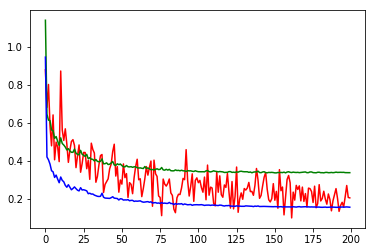

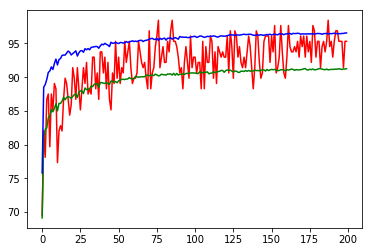

98.44	3850
91.28	8650
96.56	10000


In [18]:
#plot learining curves

# a = 225
# b = 250
    
plt.plot(l_train[1:], 'r')
plt.plot(l_val[1:], 'g')
plt.plot(l_test[1:], 'b')
plt.show()

plt.plot(train_accuracy[1:], 'r')
plt.plot(valid_accuracy[1:], 'g')
plt.plot(test_accuracy[1:], 'b')
plt.show()

print("{:.2f}".format(max(train_accuracy)), end = "\t")
print(50 * np.argmax(train_accuracy))
print("{:.2f}".format(max(valid_accuracy)), end = "\t")
print(50 * np.argmax(valid_accuracy))
print("{:.2f}".format(max(test_accuracy)), end = "\t")
print(50 * np.argmax(test_accuracy))